# INF2209 Topic Modeling on Amazon Product Reviews
Tiancheng Sheng - 1007429819

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install wordcloud gensim nltk pyLDAvis bitermplus tmplot corextopic
!pip install --upgrade gensim

from IPython.display import clear_output 
clear_output()

In [2]:
import os, json, gzip, html, re, warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tmplot as tmp
import pyLDAvis
import pyLDAvis.gensim_models
import bitermplus as btm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Nmf

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from corextopic import corextopic as ct
import scipy.sparse as ss
from collections import Counter
from pprint import pprint
from urllib.request import urlopen
from wordcloud import WordCloud, STOPWORDS

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
warnings.filterwarnings(action="ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-

## Project Setup
Data Source: [UCSD Amazon Product Review](https://jmcauley.ucsd.edu/data/amazon_v2/)

### Load Data

In [5]:
!wget --no-check-certificate https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz 

--2022-11-28 02:59:35--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/x-gzip]
Saving to: ‘Cell_Phones_and_Accessories_5.json.gz’

Cell_Phones_and_Acc 100%[===================>] 161.24M  61.4MB/s    in 2.6s    

2022-11-28 02:59:38 (61.4 MB/s) - ‘Cell_Phones_and_Accessories_5.json.gz’ saved [169071325/169071325]



In [6]:
# import data
data = []
with gzip.open('Cell_Phones_and_Accessories_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list
df_full = pd.DataFrame.from_dict(data)
df_full.dropna(how="any")
print("Dataset size: {}".format(len(df_full)))

Dataset size: 1128437


### Data Cleaning & Exploratory Data Analysis

In [7]:
# filter out reviews with only number or just too short
df_full['mask'] = df_full['reviewText'].apply(lambda line : 1 if type(line) == str and len(line) > 30 else 0)
df_full = df_full[df_full["mask"] == 1]
df_full.head()

overall  verified   reviewTime      reviewerID        asin  \
0      5.0      True   08 4, 2014  A24E3SXTC62LJI  7508492919   
1      5.0      True  02 12, 2014  A269FLZCB4GIPV  7508492919   
2      3.0      True   02 8, 2014   AB6CHQWHZW4TV  7508492919   
3      2.0      True   02 4, 2014   A1M117A53LEI8  7508492919   
4      4.0      True   02 3, 2014  A272DUT8M88ZS8  7508492919   

                  style      reviewerName  \
0  {'Color:': ' Bling'}  Claudia Valdivia   
1                   NaN       sarah ponce   
2                   NaN               Kai   
3                   NaN   Sharon Williams   
4                   NaN   Bella Rodriguez   

                                          reviewText  \
0  Looks even better in person. Be careful to not...   
1  When you don't want to spend a whole lot of ca...   
2  so the case came on time, i love the design. I...   
3  DON'T CARE FOR IT.  GAVE IT AS A GIFT AND THEY...   
4  I liked it because it was cute, but the studs ...   

                               summary  unixReviewTime vote image  mask  
0  Can't stop won't stop looking at it      1407110400  NaN   NaN     1  
1                                    1      1392163200  NaN   NaN     1  
2                             Its okay      1391817600  NaN   NaN     1  
3                                 CASE      1391472000  NaN   NaN     1  
4                                Cute!      1391385600  NaN   NaN     1

In [8]:
my_random_state = 66
stopwords_ = stopwords.words('english')
df_sampled = df_full.sample(10000, random_state=my_random_state)
df_review = df_sampled[["reviewText", "summary"]]

In [9]:
# cleaning data set: 
#   lower the text
#   remove special chars
#   remove stop words
df_review["cleaned_reviewText"] = df_review["reviewText"] \
    .apply(lambda text : str(text).lower()) \
    .apply(lambda text : re.sub(r'[^\w\s]', '', text)) \
    .apply(lambda text : " ".join([word for word in text.split(" ") if word not in stopwords_]))

print("Before cleaning: " + df_review["reviewText"][288213])
print("After cleaning: " + df_review["cleaned_reviewText"][288213])
df_review.head()

Before cleaning: This case is the best wallet case out there. It is so versitile and made well. Such a great value. GET IT!!!
After cleaning: case best wallet case versitile made well great value get


reviewText  \
548252  Came on time and a great product. Perfectly cu...   
288213  This case is the best wallet case out there. I...   
423183  I got this one for my husbands car and he real...   
437074  $30 for a plastic case?!?  Are you kidding me?...   
970855  Great screen and phone protection with back bu...   

                                                  summary  \
548252                                         Five Stars   
288213              WOW!!! BEST WALLET CASE OUT THERE!!!!   
423183  Weve had several different styles and some of ...   
437074               Excellent case but overpriced at $30   
970855  Great screen and phone protection with back bu...   

                                       cleaned_reviewText  
548252    came time great product perfectly cut fit phone  
288213  case best wallet case versitile made well grea...  
423183  got one husbands car really likes weve several...  
437074  30 plastic case  kidding  case fine  works lik...  
970855  great screen phone protection back bumpers pro...

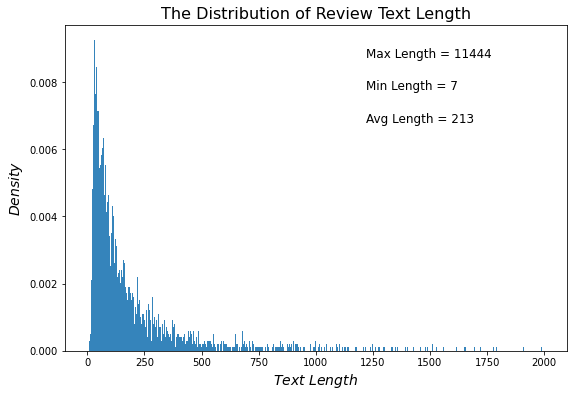

In [ ]:
# check the distribution of review text length
text_length = list(map(len, df_review["cleaned_reviewText"]))

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

ax.annotate('Max Length = ' + str(int(np.max(text_length))), xy=(0.6,0.9), xycoords='axes fraction', fontsize=12)
ax.annotate('Min Length = ' + str(int(np.min(text_length))), xy=(0.6,0.8), xycoords='axes fraction', fontsize=12)
ax.annotate('Avg Length = ' + str(int(np.mean(text_length))), xy=(0.6,0.7), xycoords='axes fraction', fontsize=12)

ax.hist(text_length, bins=np.arange(2000), density=True, alpha=0.9)
plt.title('The Distribution of Review Text Length', fontsize=16)
plt.xlabel('${Text \ Length}$', fontsize=14)
plt.ylabel('$Density$', fontsize=14)
plt.savefig("text-length.png", dpi=100)
plt.show()

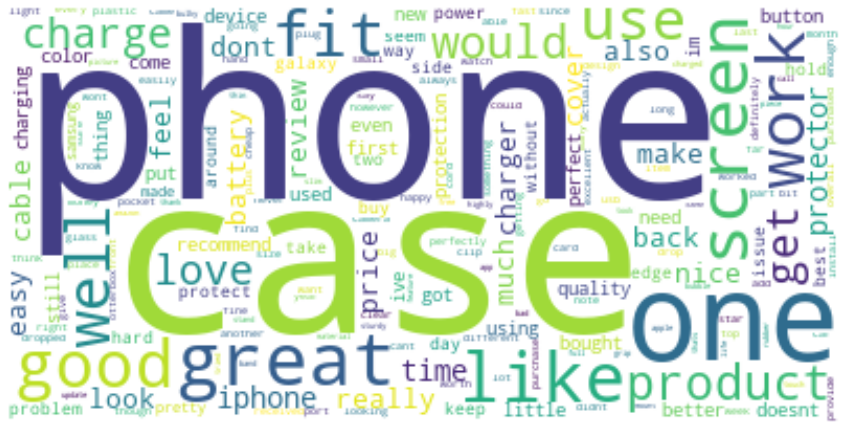

In [ ]:
# word trending
plt.figure(figsize=(15,12))
text_wordcloud = " ".join([line for line in df_review.cleaned_reviewText])
wordcloud = WordCloud(stopwords=stopwords_, background_color="white", collocations=False).generate(text_wordcloud)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("wordcloud.png", dpi=100)
plt.show()

In [ ]:
# top 20 frequent word
top_20 = pd.DataFrame(
    Counter(text_wordcloud.split(sep = " ")).most_common(20), columns = ['word', 'frequency'])
top_20 = top_20.sort_values(by = 'frequency')
top_20.to_csv("top_20.csv", index=False)
top_20

word  frequency
19    battery       1274
18  protector       1277
17     charge       1302
16      works       1358
15     really       1407
14       love       1459
13     iphone       1510
12        get       1574
11    product       1750
10      would       1879
9         use       1917
8        well       2098
7        good       2318
6        like       2650
5      screen       2685
4         one       3021
3       great       3108
2        case       6783
1       phone       7577
0                  11014

In [ ]:
# polar distribution
sentiment = SentimentIntensityAnalyzer()
df_review['score'] = df_review['cleaned_reviewText'] \
    .apply(lambda text: sentiment.polarity_scores(text)['compound'])
bins = np.arange(-1, 1.01, 0.1).tolist()

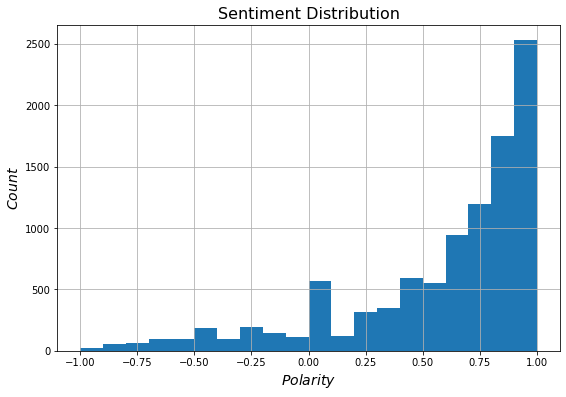

In [ ]:
plt.figure(figsize=(9,6))
df_review['score'].hist(bins=bins)
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('$Polarity$', fontsize=14)
plt.ylabel('$Count$', fontsize=14)
plt.savefig("polar-distribution.png", dpi=100)
plt.show()

## Model 1: LDA

In [10]:
tag_dict = {
    "J": wordnet.ADJ,
    "V": wordnet.VERB,
    "N": wordnet.NOUN,
    "R": wordnet.ADV
}

lemmatizer = WordNetLemmatizer()

In [11]:
df_review["lemmatized_reviewText"] = df_review["cleaned_reviewText"] \
    .apply(nltk.word_tokenize) \
    .apply(nltk.tag.pos_tag) \
    .apply(lambda text : [(word, tag_dict.get(tag, wordnet.NOUN)) for (word, tag) in text]) \
    .apply(lambda text : [lemmatizer.lemmatize(word, tag) for (word, tag) in text])

df_review["lemmatized_reviewText_btm"]= df_review["lemmatized_reviewText"] \
    .apply(lambda text : " ".join(text))

df_review.head()

reviewText  \
548252  Came on time and a great product. Perfectly cu...   
288213  This case is the best wallet case out there. I...   
423183  I got this one for my husbands car and he real...   
437074  $30 for a plastic case?!?  Are you kidding me?...   
970855  Great screen and phone protection with back bu...   

                                                  summary  \
548252                                         Five Stars   
288213              WOW!!! BEST WALLET CASE OUT THERE!!!!   
423183  Weve had several different styles and some of ...   
437074               Excellent case but overpriced at $30   
970855  Great screen and phone protection with back bu...   

                                       cleaned_reviewText  \
548252    came time great product perfectly cut fit phone   
288213  case best wallet case versitile made well grea...   
423183  got one husbands car really likes weve several...   
437074  30 plastic case  kidding  case fine  works lik...   
970855  great screen phone protection back bumpers pro...   

                                    lemmatized_reviewText  \
548252  [came, time, great, product, perfectly, cut, f...   
288213  [case, best, wallet, case, versitile, made, we...   
423183  [got, one, husband, car, really, like, weve, s...   
437074  [30, plastic, case, kidding, case, fine, work,...   
970855  [great, screen, phone, protection, back, bumpe...   

                                lemmatized_reviewText_btm  
548252    came time great product perfectly cut fit phone  
288213  case best wallet case versitile made well grea...  
423183  got one husband car really like weve several d...  
437074  30 plastic case kidding case fine work like 10...  
970855  great screen phone protection back bumper prov...

In [12]:
data_words = df_review["lemmatized_reviewText"].values.tolist()

id2word = corpora.Dictionary(data_words)
id2word.filter_extremes(no_below=20, no_above=0.5)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


### Find the optimal number of topics

In [ ]:
number_of_topics = np.arange(3, 31, 3)

In [ ]:
perplexity_lda = []
coherence_lda = []

for num in number_of_topics:
    lda_model = gensim.models.LdaMulticore(
        corpus=corpus, 
        id2word=id2word, 
        num_topics=num)

    p = lda_model.log_perplexity(corpus)
    perplexity_lda.append(p)

    cm = CoherenceModel(
        model=lda_model, 
        corpus=corpus, 
        coherence='u_mass')
    
    c = cm.get_coherence()
    coherence_lda.append(c)

In [ ]:
print(perplexity_lda)
print(coherence_lda)

[-6.576861267246666, -6.667911650526121, -6.697777903126206, -6.740207099152578, -6.781479878375795, -6.79161013632937, -6.824553088494979, -6.891455399718977, -6.903695809648821, -6.989655414936381]
[-1.6779035605403692, -1.804268652182663, -1.825440640694314, -1.8011454512879064, -1.8088134838885956, -1.9507936439326383, -1.944158469298888, -1.9054957942238548, -1.960969128441677, -1.9082484547079612]


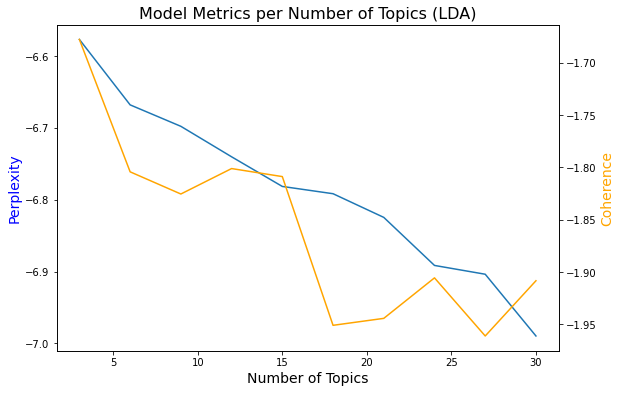

In [ ]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(x=number_of_topics, y=perplexity_lda)
ax.set_ylabel('Perplexity', color='blue', fontsize=14)
ax2=ax.twinx()
ax2 = sns.lineplot(x=number_of_topics, y=coherence_lda, color='orange')
ax2.set_ylabel('Coherence', color='orange', fontsize=14)

ax.axes.set_title('Model Metrics per Number of Topics (LDA)', fontsize=16)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.savefig("lda.png", dpi=100)
plt.show()   

In [ ]:
# Using the best model on number of topics
best_number_lda = 10
lda_model_best = gensim.models.LdaMulticore(
    corpus=corpus, id2word=id2word, num_topics=best_number_lda)

pprint(lda_model_best.print_topics())
doc_lda = lda_model_best[corpus]

[(0,
  '0.020*"cable" + 0.016*"phone" + 0.016*"product" + 0.014*"good" + '
  '0.013*"one" + 0.012*"love" + 0.011*"charger" + 0.011*"great" + 0.011*"5" + '
  '0.010*"use"'),
 (1,
  '0.028*"phone" + 0.024*"screen" + 0.019*"case" + 0.014*"protector" + '
  '0.012*"iphone" + 0.010*"like" + 0.008*"use" + 0.008*"get" + 0.008*"work" + '
  '0.008*"also"'),
 (2,
  '0.046*"phone" + 0.035*"case" + 0.023*"great" + 0.023*"good" + 0.016*"well" '
  '+ 0.013*"like" + 0.012*"fit" + 0.011*"would" + 0.010*"screen" + '
  '0.010*"protection"'),
 (3,
  '0.029*"phone" + 0.022*"case" + 0.013*"charger" + 0.010*"fit" + '
  '0.009*"charging" + 0.009*"battery" + 0.008*"like" + 0.008*"work" + '
  '0.008*"good" + 0.008*"well"'),
 (4,
  '0.045*"case" + 0.033*"phone" + 0.014*"one" + 0.011*"cover" + 0.009*"like" + '
  '0.008*"good" + 0.008*"get" + 0.007*"dont" + 0.007*"great" + '
  '0.006*"protection"'),
 (5,
  '0.036*"case" + 0.021*"like" + 0.019*"one" + 0.018*"fit" + 0.017*"phone" + '
  '0.012*"well" + 0.011*"look" +

In [ ]:
pyLDAvis.enable_notebook()
lda_model_best_vis = pyLDAvis.gensim_models.prepare(lda_model_best, corpus, id2word)
lda_model_best_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.017940  0.006371       1        1  14.508436
4      0.032451  0.007090       2        1  14.424026
1      0.015895 -0.024958       3        1  13.500771
6      0.003394 -0.004184       4        1   9.764503
2      0.045701 -0.036515       5        1   9.508452
9      0.013471 -0.022206       6        1   9.194926
3      0.004873  0.029475       7        1   8.086350
5      0.023849  0.036610       8        1   7.943907
0     -0.087298 -0.028967       9        1   7.605564
8     -0.034396  0.037285      10        1   5.463064, topic_info=        Term         Freq        Total Category  logprob  loglift
92     cable  1051.000000  1051.000000  Default  30.0000  30.0000
5      phone  8662.000000  8662.000000  Default  29.0000  29.0000
9       case  7757.000000  7757.000000  Default  28.0000  28.0000
65      good  2588.000000  2588.000000  Default  27.0000  27.0000
94   charger  1329.000000  1329.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
82      look    84.148104  1504.494704  Topic10  -5.2182   0.0235
33      like   100.079639  2701.250427  Topic10  -5.0448  -0.3883
10       get    83.849976  1717.193418  Topic10  -5.2217  -0.1123
100        i    68.280434   899.889870  Topic10  -5.4271   0.3285
161       go    62.802228   742.633425  Topic10  -5.5108   0.4369

[735 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
604       2  0.049949    13
604       3  0.249744    13
604       4  0.099898    13
604       5  0.099898    13
604       6  0.099898    13
...     ...       ...   ...
1266      4  0.088988  zagg
1266      5  0.035595  zagg
1266      7  0.017798  zagg
1266      8  0.231370  zagg
1266      9  0.071191  zagg

[4241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 7, 3, 10, 4, 6, 1, 9])

## Model 2: NMF

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_, ngram_range = (1,1), max_df = .8, min_df = .01)

# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
tfidf = tfidf_vectorizer.fit_transform(df_review['lemmatized_reviewText_btm'])
tfidf_dtm = pd.DataFrame(tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_dtm.head()

10  100        30  able  absolutely  access  actually  adapter  add  \
0  0.000000  0.0  0.000000   0.0         0.0     0.0       0.0      0.0  0.0   
1  0.000000  0.0  0.000000   0.0         0.0     0.0       0.0      0.0  0.0   
2  0.000000  0.0  0.000000   0.0         0.0     0.0       0.0      0.0  0.0   
3  0.196759  0.0  0.427853   0.0         0.0     0.0       0.0      0.0  0.0   
4  0.000000  0.0  0.000000   0.0         0.0     0.0       0.0      0.0  0.0   

   advertised  ...  working  worry  worth  would  wouldnt  wrong  year  yes  \
0         0.0  ...      0.0    0.0    0.0    0.0      0.0    0.0   0.0  0.0   
1         0.0  ...      0.0    0.0    0.0    0.0      0.0    0.0   0.0  0.0   
2         0.0  ...      0.0    0.0    0.0    0.0      0.0    0.0   0.0  0.0   
3         0.0  ...      0.0    0.0    0.0    0.0      0.0    0.0   0.0  0.0   
4         0.0  ...      0.0    0.0    0.0    0.0      0.0    0.0   0.0  0.0   

   yet  youre  
0  0.0    0.0  
1  0.0    0.0  
2  0.0    0.0  
3  0.0    0.0  
4  0.0    0.0  

[5 rows x 513 columns]

### Find the optimal number of topics

In [ ]:
_nmf = []

dict_nmf = corpora.Dictionary(texts)

for num in number_of_topics:
    nmf_model = Nmf(
        corpus=corpus, 
        num_topics=num, 
        id2word=id2word, 
        random_state=my_random_state)

    cm = CoherenceModel(
        model=nmf_model, 
        texts=texts, 
        dictionary=dict_nmf, 
        coherence='u_mass')
    
    c = cm.get_coherence()
    coherence_nmf.append(c)

In [ ]:
print(coherence_nmf)

[-5.571629320014657, -6.098593661858117, -7.5564771544575695, -7.637700752811139, -7.225738992114836, -7.580734768174377, -7.944806400883178, -8.065525720559625, -8.077214482962988, -8.481483524135717]


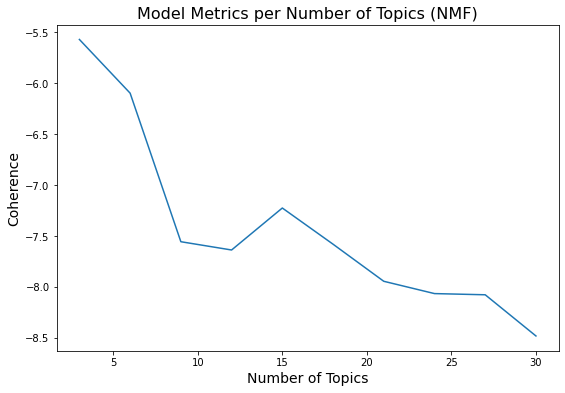

In [ ]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(
    x=number_of_topics, y=coherence_nmf)
ax.axes.set_title('Model Metrics per Number of Topics (NMF)', fontsize=16)
ax.set_ylabel('Coherence', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.savefig("nmf.png", dpi=100)
plt.show()  

In [ ]:
best_number_nmf = 5

nmf = NMF(
    n_components=best_number_nmf, 
    random_state=my_random_state, 
    alpha=.1, 
    init='nndsvd')

doc_topic = nmf.fit_transform(tfidf_dtm)

display_topics(
    nmf, 
    tfidf_vectorizer.get_feature_names(), 
    10)

Topic 0:
case phone fit love like nice protection look color iphone
Topic 1:
charge phone charger battery one cable charging use work device
Topic 2:
screen protector glass edge easy bubble phone install cover one
Topic 3:
great work product love fit price well perfectly perfect easy
Topic 4:
good product quality price look nice excellent like recommend feel


## Model 3: BTM

In [ ]:
texts_btm = df_review["lemmatized_reviewText_btm"].tolist()
X, vocabulary, vocab_dict = btm.get_words_freqs(texts_btm, stop_words=stopwords_)

# vectorizing documents
docs_vec = btm.get_vectorized_docs(texts_btm, vocabulary)
docs_lens = list(map(len, docs_vec))

# generating biterms
biterms = btm.get_biterms(docs_vec)

### Find the optimal number of topics

In [ ]:
perplexity_btm = []
coherence_btm = []

for num in number_of_topics:
    btm_model = btm.BTM(
    X, vocabulary, seed=my_random_state, T=num, M=20, alpha=50/8, beta=0.01)
    btm_model.fit(biterms, iterations=100)

    perplexity_btm.append(btm_model.perplexity_)
    coherence_btm.append(np.average(btm_model.coherence_))

100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


In [ ]:
print(perplexity_btm)
print(coherence_btm)

[101644.72477234178, 2.1346997795058404e+303, 27832.752188987302, 1.1301109787754182, 3.246171210437253e+248, 1.271124383574644, 13.479658880213343, inf, 1.4425157699974629e+305, inf]
[-325.8634437967549, -338.27345903877534, -354.02095729639444, -364.5141537522784, -375.6777911826984, -358.2767926336232, -375.0562234598893, -362.57383845276155, -371.5035168445819, -374.1588229240214]


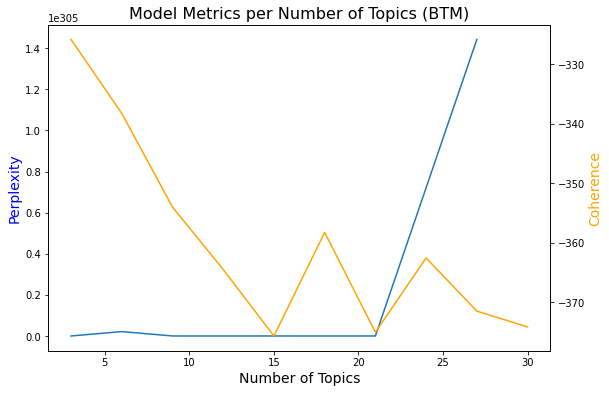

In [ ]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(x=number_of_topics, y=perplexity_btm)
ax.set_ylabel('Perplexity', color='blue', fontsize=14)
ax2=ax.twinx()
ax2 = sns.lineplot(x=number_of_topics, y=coherence_btm, color='orange')
ax2.set_ylabel('Coherence', color='orange', fontsize=14)

ax.axes.set_title('Model Metrics per Number of Topics (BTM)', fontsize=16)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.savefig("btm.png", dpi=100)
plt.show()  

In [ ]:
# modeling
best_number_btm = 10

model = btm.BTM(
    X, 
    vocabulary, 
    seed=my_random_state, 
    T=best_number_btm, 
    M=20, 
    alpha=50/8, 
    beta=0.01)

model.fit(biterms, iterations=20)

100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


## Model 4: CorEx

In [14]:
vectorizer = CountVectorizer(max_features=10000, binary=True)
doc_word = vectorizer.fit_transform(df_review['lemmatized_reviewText_btm'])
doc_word = ss.csr_matrix(doc_word)

docs = df_review.index.tolist()
words = list(np.asarray(vectorizer.get_feature_names()))
words[:5]

['01', '05', '05mm', '10', '100']

In [ ]:
correlation = []

for num in number_of_topics:
    corex_model = ct.Corex(
        n_hidden=num, 
        words=words, 
        max_iter=100, 
        verbose=False, 
        seed=my_random_state)
    
    corex_model.fit(
        doc_word, 
        words=words, 
        docs=docs)
    
    correlation.append(corex_model.tc)

In [ ]:
print(correlation)

[10.93809944677194, 11.20787972249457, 11.95705964173151, 11.879709441049588, 11.81052454131399, 11.884639430044238, 11.826531890625215, 11.634868083831027, 11.453903089756539, 11.08199145255773]


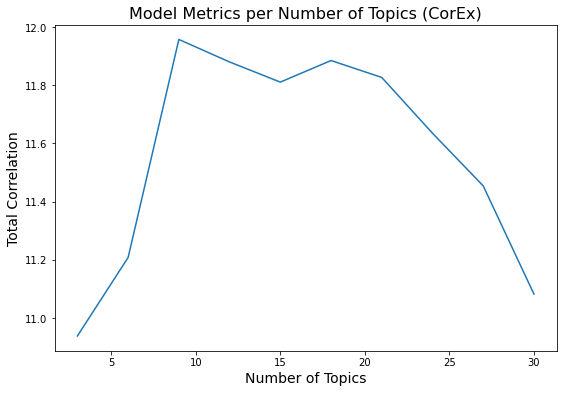

In [ ]:
plt.figure(figsize=(9, 6))
ax = sns.lineplot(x=number_of_topics, y=correlation)
ax.axes.set_title('Model Metrics per Number of Topics (CorEx)', fontsize=16)
ax.set_ylabel('Total Correlation', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.savefig("corex.png", dpi=100)
plt.show()  

In [16]:
best_model_corex = 9

corex_model = ct.Corex(
    n_hidden=best_model_corex, 
    words=words, 
    max_iter=200, 
    verbose=False,
    seed=my_random_state)

corex_model.fit(
    doc_word, 
    words=words, 
    docs=docs)


for i in range(0, 9):
    print(corex_model.get_topics(topic=i, n_words=5))

[('using', 0.039065066493393634, 1.0), ('take', 0.030627535270584753, 1.0), ('hour', 0.02832924388714418, 1.0), ('issue', 0.02788333422432481, 1.0), ('ive', 0.025842792978009475, 1.0)]
[('review', 0.12277073332661212, 1.0), ('honest', 0.06993549613755952, 1.0), ('received', 0.057228711576578946, 1.0), ('dont', 0.05114053487220071, 1.0), ('exchange', 0.04295678963004028, 1.0)]
[('the', 0.07032134344513308, 1.0), ('button', 0.06025657853162871, 1.0), ('get', 0.05504741617877256, 1.0), ('make', 0.05466842456335463, 1.0), ('im', 0.048330924565708665, 1.0)]
[('also', 0.08680422054574086, 1.0), ('like', 0.07855431638844557, 1.0), ('back', 0.07352743758096114, 1.0), ('would', 0.06326147671827292, 1.0), ('side', 0.048249444911573465, 1.0)]
[('charge', 0.1544162566231254, 1.0), ('charger', 0.119428208026087, 1.0), ('charging', 0.1004631814477253, 1.0), ('usb', 0.08719394042026384, 1.0), ('battery', 0.07289331971845564, 1.0)]
[('screen', 0.17889317870068377, 1.0), ('protector', 0.173219911344452